# Toy Example

This notebook provides several experiments, that allow us to compare [Pyro](http://pyro.ai/) implementation of SVI and our implementation.

We consider pretty simple probabilistic model with one global latent variable $\mu$:
$$
p(x | \mu) \sim \mathcal{N}(\mu, 1), \quad p(\mu) \sim \mathcal{N}(0, 1) \\
p(X, \mu) = p(\mu) \prod_{i=1}^N p(x_i | \mu).
$$

We set our variational distribution $q(\mu)$, which approximates a posterior $p(\mu | X)$, to be Gaussian too. Initial $q(\mu)$ is set to be a standard Gaussian. Then we apply SVI to obtain real posterior parameters. In this example we don't tune parameters of $p$.

We choose prior on $\mu$ to be conjugate to the our conditional likelihood in order to be able to compute real posterior parameters analytically. In our case 
$$
p(\mu | X) = \mathcal(N) \Bigg(\dfrac{\sum_{i=1}^N x_i}{N + 1}, \dfrac{1}{N + 1} \Bigg).
$$
For more details see [Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior)

In [1]:
# general libraries
import os
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import Parameter
from torch.autograd import Variable
import torch.distributions.constraints as constraints

# Pyro libraries
import pyro
from pyro.optim import Adam
from pyro.infer import SVI as Pyro_SVI, Trace_ELBO
import pyro.distributions as dist

# Our SVI functions
from BBSVI import SVI as Our_SVI
from BBSVI import HistoryCollector

# Generating Data

Here we set real $\mu$ to be equal to $2.5$ and generate observed data. After that we will not use $\mu$. Instead, we will reconstruct $\mu$ based only on the observed examples.

In [2]:
mu = 2.5
np.random.seed(42)
num_samples = 1000
data = torch.Tensor(np.random.normal(mu, 1., size=num_samples))

# Our models

Below we define classes, which implements distributions $p$ and $q$ defined above. We will use KL-form of the ELBO, so we also define function which computes [KL-divergency](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) beetwen prior on $\mu$ and our approximation of posterior.

In [3]:
class Prior:
    def __init__(self):
        self.prior = torch.distributions.Normal(torch.zeros(1), torch.ones(1))
        
    def log_likelihood_global(self, beta):
        return self.prior.log_prob(beta)
    
    def log_likelihood_joint(self, x, z, beta):
        cond = torch.distributions.Normal(beta, torch.ones(1))
        return cond.log_prob(x)
    
    def log_likelihood_cond(self, x, z, beta):
        cond = torch.distributions.Normal(beta, torch.ones(1))
        return cond.log_prob(x)

In [4]:
class VariationalDistribution:
    def __init__(self):
        self.mu = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.sigma = nn.Parameter(torch.ones(1), requires_grad=True)
        self.distr = torch.distributions.Normal(self.mu, self.sigma)
        self.parameters = [self.mu, self.sigma]
        
    def sample_global(self):
        return self.distr.rsample()
    
    def sample_local(self, beta, idx):
        return None
    
    def entropy(self, batch_indices):
        return self.distr.entropy()

In [5]:
def kl(var, prior, batch_indices):
    return torch.distributions.kl_divergence(var.distr, prior.prior)

# Our SVI Inference

Here we do SVI based on two forms of ELBO: KL form and entropy form.

In [6]:
analytical_mu = torch.sum(data) / (1 + num_samples)
analytical_sigma = np.sqrt(1 / (1 + num_samples))

prior = Prior()
var = VariationalDistribution()
opt = torch.optim.Adam(var.parameters, lr=1e-3)
our_svi = Our_SVI(data, prior, var, opt)

history_collector_ent = HistoryCollector(data.shape[0])

foo = history_collector_ent.collect_history

num_steps = 50
discounter_schedule = torch.Tensor(np.linspace(0, 1, num_steps))

print('Prior params:                             \t mu=%.2f \t sigma=%.2f' % (var.mu, var.sigma))

start_time = time.time()
our_svi.make_inference(num_steps=num_steps, num_samples=1, loss='entropy', print_progress=True, 
                       discounter_schedule=None, callback=foo)

svi_time = time.time() - start_time

print('Entropy form VI Posterior params:         \t mu=%.2f \t sigma=%.2f' % (var.mu, var.sigma))
print('Analytical Posterior params:              \t mu=%.2f \t sigma=%.2f' % (analytical_mu, analytical_sigma))
print("Number of steps: ", num_steps, " Time: ", svi_time)

Prior params:                             	 mu=0.00 	 sigma=1.00
..................................................
Entropy form VI Posterior params:         	 mu=2.48 	 sigma=0.05
Analytical Posterior params:              	 mu=2.52 	 sigma=0.03
Number of steps:  50  Time:  8.396536827087402


In [7]:
analytical_mu = torch.sum(data) / (1 + num_samples)
analytical_sigma = np.sqrt(1 / (1 + num_samples))

prior = Prior()
var = VariationalDistribution()
opt = torch.optim.Adam(var.parameters, lr=1e-3)
our_svi = Our_SVI(data, prior, var, opt)

history_collector_kl = HistoryCollector(data.shape[0])

foo = history_collector_kl.collect_history

num_steps = 50
discounter_schedule = torch.Tensor(np.linspace(0, 1, num_steps))

print('Prior params:                \t mu=%.2f \t sigma=%.2f' % (var.mu, var.sigma))

start_time = time.time()
our_svi.make_inference(num_steps=num_steps, num_samples=1, loss='kl', print_progress=True, 
                       discounter_schedule=None, callback=foo, kl=kl)

svi_time = time.time() - start_time

print('VI Posterior params:         \t mu=%.2f \t sigma=%.2f' % (var.mu, var.sigma))
print('Analytical Posterior params: \t mu=%.2f \t sigma=%.2f' % (analytical_mu, analytical_sigma))
print("Number of steps: ", num_steps, " Time: ", svi_time)

Prior params:                	 mu=0.00 	 sigma=1.00
..................................................
VI Posterior params:         	 mu=2.48 	 sigma=0.05
Analytical Posterior params: 	 mu=2.52 	 sigma=0.03
Number of steps:  50  Time:  11.37984299659729


# Pyro models

This model Pyro implementation is based on the [first example](http://pyro.ai/examples/svi_part_i.html) of SVI in Pyro from their documentation

In [8]:
def model(data):
    
    # define the hyperparameters that control the Normal prior
    mu0 = torch.tensor(0.)
    sigma0 = torch.tensor(1.)
    
    # sample f from the Normal prior
    f = pyro.sample("latent_variable", dist.Normal(mu0, sigma0))
    
    # loop over the observed data
    for i in range(len(data)):
        
        # observe datapoint i using the Normal
        # likelihood Normal(f, 1)
        
        pyro.sample("obs_{}".format(i), dist.Normal(f, torch.tensor(1.)), obs=data[i])


In [9]:
def guide(data):
    
    # register the two variational parameters with Pyro
    # - mu parameter will have initial value 0
    # - sigma parameter will have initial value 1
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    
    mu_q = pyro.param("mu_q", torch.tensor(0.))
    
    sigma_q = pyro.param("sigma_q", torch.tensor(1.),
                        constraint=constraints.positive)
    
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_variable", dist.Normal(mu_q, sigma_q))

# Pyro SVI inference

In [10]:
n_steps = 50

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case
pyro.clear_param_store()

In [11]:
# setup the optimizer
adam_params = {"lr": 0.1, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
pyro_svi = Pyro_SVI(model, guide, optimizer, loss=Trace_ELBO())


pyro_loss_history = []


start_time = time.time()

# do gradient steps
for step in range(num_steps):
        
    cur_loss = pyro_svi.step(data)

    pyro_loss_history.append(cur_loss)

pyro_time = time.time() - start_time

# grab the learned variational parameters
mu_q = pyro.param("mu_q").item()
sigma_q = pyro.param("sigma_q").item()


print('VI Posterior params:         \t mu=%.2f \t sigma=%.2f' % (mu_q, sigma_q))
print('Analytical Posterior params: \t mu=%.2f \t sigma=%.2f' % (analytical_mu, analytical_sigma))
print("Number of steps: ", num_steps, " Time: ", pyro_time)

VI Posterior params:         	 mu=2.80 	 sigma=0.39
Analytical Posterior params: 	 mu=2.52 	 sigma=0.03
Number of steps:  50  Time:  12.84861707687378


# Plotting

In [12]:
def plot_losses(our_loss_ent, our_loss_kl, pyro_loss, our_time, pyro_time, num_steps = 50):
    
    fig = plt.figure(figsize = (12, 12))

    ax = fig.add_subplot(111, xlabel = "time", ylabel = "loss", title = "Pyro and Our SVI comparison")
    
    ax.plot(np.linspace(0, our_time, num_steps), our_loss_ent, label = "Our Loss in Entropy From")
    ax.plot(np.linspace(0, our_time, num_steps), our_loss_kl, label = "Our Loss in KL From")
    ax.plot(np.linspace(0, pyro_time, num_steps), pyro_loss, label = "Pyro Loss")
    
    ax.set_title("Pyro and Our SVI comparison", size = 20)
    ax.set_xlabel("Time", size = 20)
    ax.set_ylabel("Loss", size = 20)
    
    ax.legend(fontsize=16)
    
    plt.show()

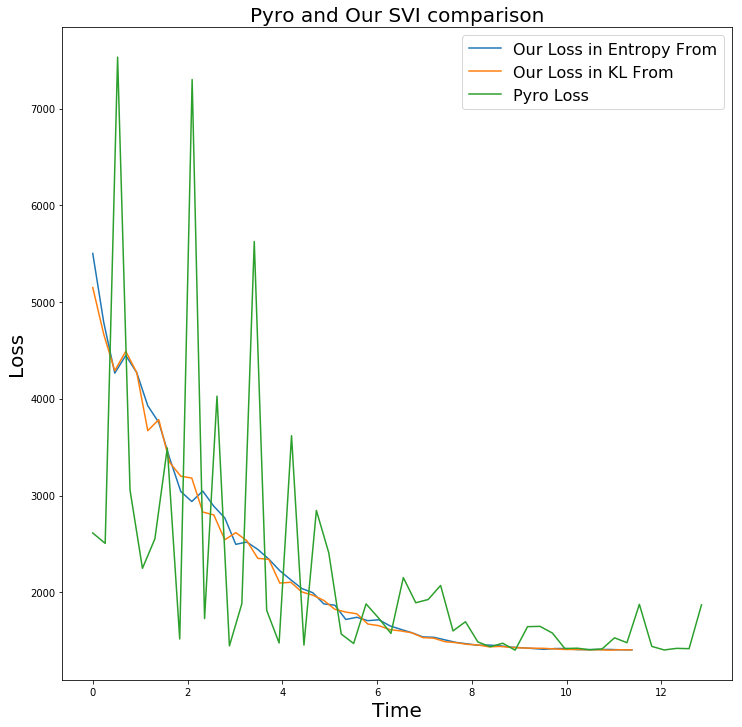

In [13]:
plot_losses(history_collector_ent.history, history_collector_kl.history, pyro_loss_history, svi_time, pyro_time)

Note that in both ours and Pyro inference only one sample is used for approximating ELBO. Much greater variance of Pyro loss can be explained through the fact that in our models we used learning rate equals to $10^{-3}$ and in the Pyro one equals to $10^{-1}$. Setting Pyro learning rate equals to $10^{-3}$ reduces divergency, but then it fails to converge in competible time.